##Unsupervised Learning Part 2

The purpose of this section is to increase the number of US CBSAs that can be clustered by imputing the cluster labels (using knn) for CBSAs with some missing data in the 6 key pollutants. Then, we wanted to see if the clusters made in the US data could be used to classify the French data. 

In [242]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
from time import time
import operator 

####Import US data

In [159]:
clusters = pd.read_csv('dfClusters_kMeans.csv')
us_year = pd.read_csv('YearDat.csv')

####Import French data

In [410]:
france = pd.read_csv('FranceYearDat.csv')

###Impute cluster label of US cities with missing data in the 6 pollutants

In the previous cluster creation, only 80 of the 533 US CBSAs were able to be used because of missing data in the 6 key pollutants. So, to increase our sample size, we will use knn to impute the cluster assignment in the CBSAs with only one or two missing values (i.e., with data for 4 or 5 pollutants).

####What CBSAs have only one or two missing values in the key pollutants?

In [166]:
pollutants = ['CO', 'NO2', 'OZONE', 'PM10', 'PM25_FRMFEM', 'SO2']

#us_year_p is the dataframe with only the 6 pollutants, with CBSA name as the index. 
us_year_p = us_year.loc[:, ['CBSA Name', 'CO', 'NO2', 'OZONE', 'PM10', 'PM25_FRMFEM', 'SO2']]

In [172]:
#generate lists of CBSAs with data from 4 or 5 pollutants
us_p4 = []
us_p5 = []
for i, row in us_year_p.iterrows(): 
    count = []
    for item in row.index[1:]:
        if np.isnan(row[item]):
            count.append(1)
    if sum(count) == 1:
        us_p5.append(row['CBSA Name'])
    if sum(count) == 2:
        us_p4.append(row['CBSA Name'])

In [173]:
#how many CBSAs do we have with 4 or 5 pollutants?
print '%d CBSAs with non-missing data from 4 pollutants' %len(us_p4)
print '%d CBSAs with non-missing data from 5 pollutants' %len(us_p5)

64 CBSAs with non-missing data from 4 pollutants
42 CBSAs with non-missing data from 5 pollutants


There are 106 additional CBSAs that we can potentially add to our clustering. 

####Use knn to impute the cluster label

Adapted from: http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

In [375]:
#full dataframe with 4 or 5 pollutants
us_year_pi = us_year_p.set_index('CBSA Name')
us_year_p4 = us_year_pi.loc[us_p4, :]
us_year_p5 = us_year_pi.loc[us_p5, :]

Write a function to find similarity between these CBSAs and the no missing data CBSAs. I used euclidean distance to calculate similarity.

In [376]:
def euclidean(miss_city, nonmiss_city, pollutant):
    distance = 0
    for pol in pollutant:
        distance += pow((miss_city[pol] - nonmiss_city[pol]), 2)
    return np.sqrt(distance)

I need to write a function that gives the right inputs to the euclidean function and iterates through all the cities.

In [377]:
def neighbors(clusteredcities, miss_city, k):
    distances = []
    #since the missing pollutant was different for each city, the "cols" list contains the pollutants with data.
    cols = []
    for x in range(len(miss_city)):
        if np.isnan(miss_city[x])==False:
            cols.append(miss_city.index[x])
    for x in range(len(clusteredcities)):
        dist = euclidean(miss_city, clusteredcities.iloc[x], cols)
        distances.append((clusteredcities.iloc[x], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

This 'neighbors' function gets the k nearest cities to a given city with missing values. The next function looks at the clusters in the neighboring cities and 'votes' for the most represented cluster.

In [378]:
def response(neighbors):
    classVotes = {}
    for x in range(len(neighbors)):
        response = neighbors[x]['Cluster']
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    sortedVotes = sorted(classVotes.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

Finally, we put the functions together and get imputed clusters for each of our 106 cities with some missing data.

In [379]:
#for 4 pollutants
us_year_p4['Cluster'] = 0
for x in range(len(us_year_p4)):
    knn_clust = response(neighbors(clusters, us_year_p4.iloc[x,:], k=5))
    us_year_p4['Cluster'][x] = knn_clust

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [380]:
#same for 5 pollutants
us_year_p5['Cluster'] = 0
for x in range(len(us_year_p5)):
    knn_clust = response(neighbors(clusters, us_year_p5.iloc[x,:], k=5))
    us_year_p5['Cluster'][x] = knn_clust

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Output a .csv of all the clustered CBSAs so far.

In [381]:
us_year_p5['CBSA'] = us_year_p5.index
us_year_p4['CBSA'] = us_year_p4.index
allclusters = pd.concat([clusters, us_year_p4, us_year_p5])

In [382]:
allclusters = allclusters.reset_index(drop = True)

In [384]:
allclusters.to_csv("clusters_knn.csv",index=False,na_rep='NA')

###Visualize the clusters with the added CBSAs. How do they compare to the non-imputed clusters?

Note: some reuse of code from Unsupervised Learning part 1

In [550]:
all_means = allclusters.groupby('Cluster').mean()
print 'Means by cluster and pollutant'
all_means

Means by cluster and pollutant


,CO,NO2,OZONE,PM10,PM25_FRMFEM,SO2
Cluster,,,,,,
0,0.417289,11.658035,0.030033,28.383675,10.915097,1.946835
1,0.357104,5.433409,0.030344,18.325607,8.784917,1.343216
2,0.347346,7.848355,0.030453,12.552106,8.563082,1.687748
3,0.396073,11.529205,0.029707,19.813070,10.929289,2.069328


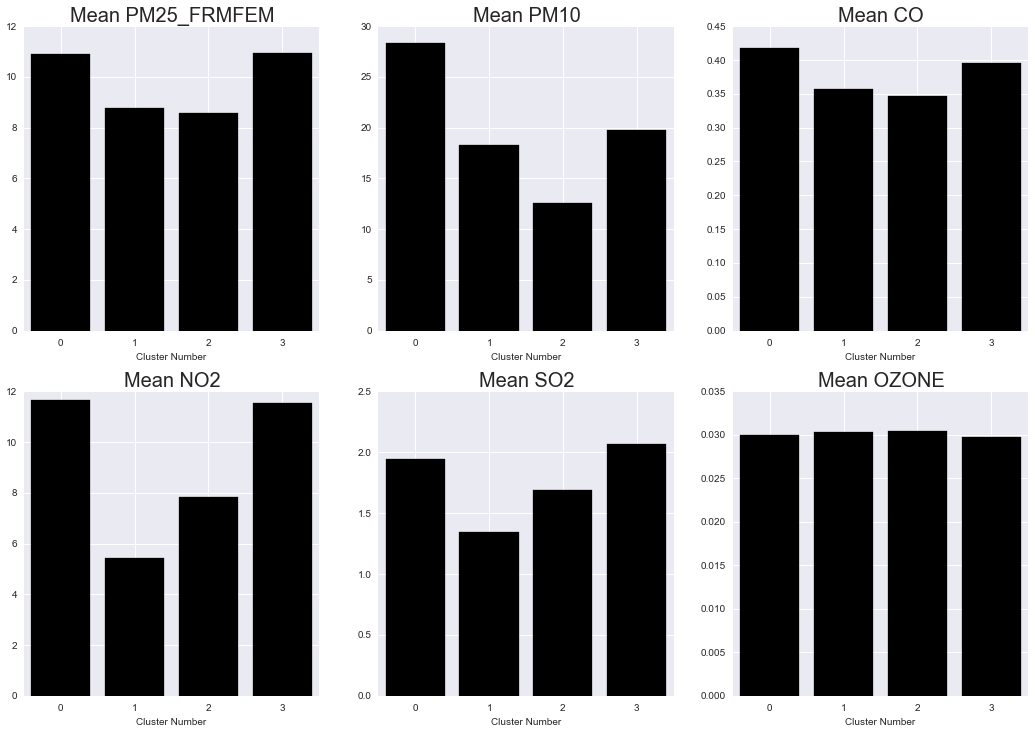

In [551]:
fig = plt.figure(figsize=(18,12))
names=['0','1','2','3']
plt.subplot(2, 3, 1)
plt.bar(all_means.index,all_means['PM25_FRMFEM'],color='black',align='center')
plt.title('Mean PM25_FRMFEM',fontsize=20)
plt.xticks(all_means.index, names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)

plt.subplot(2, 3, 2)
plt.bar(all_means.index,all_means['PM10'],color='black',align='center')
plt.title('Mean PM10',fontsize=20)
plt.xticks(all_means.index, names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)

plt.subplot(2, 3, 3)
plt.bar(all_means.index,all_means['CO'],color='black',align='center')
plt.title('Mean CO',fontsize=20)
plt.xticks(all_means.index, names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)
  
plt.subplot(2, 3, 4)
plt.bar(all_means.index,all_means['NO2'],color='black',align='center')
plt.title('Mean NO2',fontsize=20)
plt.xticks(all_means.index, names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)

plt.subplot(2, 3, 5)
plt.bar(all_means.index,all_means['SO2'],color='black',align='center')
plt.title('Mean SO2',fontsize=20)
plt.xticks(all_means.index, names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)

plt.subplot(2, 3, 6)
plt.bar(all_means.index,all_means['OZONE'],color='black',align='center')
plt.title('Mean OZONE',fontsize=20)
plt.xticks(all_means.index, names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)


###Clustering French data

####Data prep

First, I cut down the size of the french dataset to hold only the 6 key pollutants, and the cities that that have two or fewer missing values. 

In [505]:
fr_6p = france.loc[:, ['city', 'CO', 'NO2', 'OZONE', 'PM10', 'PM25', 'SO2']]
#generate lists of French cities with data from 4 or 5 pollutants
fr_4 = []
fr_5 = []
fr_6 = []
for i, row in fr_6p.iterrows(): 
    count = []
    for item in row.index[1:]:
        if np.isnan(row[item]):
            count.append(1)
    if sum(count) == 1:
        fr_5.append(row['city'])
    if sum(count) == 2:
        fr_4.append(row['city'])
    if sum(count) == 0:
        fr_6.append(row['city'])

In [506]:
print '%d French cities with non-missing data from 4 pollutants' %len(fr_4)
print '%d French cities with non-missing data from 5 pollutants' %len(fr_5)
print '%d French cities with non-missing data from all 6 pollutants' %len(fr_6)

20 French cities with non-missing data from 4 pollutants
20 French cities with non-missing data from 5 pollutants
29 French cities with non-missing data from all 6 pollutants


In [507]:
fr_pi = fr_6p.set_index('city')
fr_p4 = fr_pi.loc[fr_4, :]
fr_p5 = fr_pi.loc[fr_5, :]
fr_p6 = fr_pi.loc[fr_6, :]

In [508]:
fr_p = pd.concat([fr_p4,fr_p5,fr_p6])

In [509]:
fr_p = fr_p.rename(columns={'PM25': 'PM25_FRMFEM'})

####Assign clusters on French cities based on US clustering

I use the knn functions written above

In [510]:
frclusts = pd.Series(index=fr_p.index)
for x in range(len(fr_p)):
    knn_clust = response(neighbors(allclusters, fr_p.iloc[x,:], k=5))
    frclusts[x] = knn_clust

In [511]:
#merge the series containing the cluster labels with the dataframe with the french cities
fr_p_clusts = pd.concat([fr_p, frclusts], axis=1)

In [520]:
fr_p_clusts = fr_p_clusts.rename(columns={0: 'Cluster'})

####What do the French clusters look like?

In [528]:
fr_group = fr_p_clusts.groupby('Cluster')
fr_group.count()

,CO,NO2,OZONE,PM10,PM25_FRMFEM,SO2
Cluster,,,,,,
0,22,37,37,37,24,32
1,0,1,1,1,0,1
3,15,31,31,30,25,29


In [553]:
fr_means = fr_group.mean()
fr_means

,CO,NO2,OZONE,PM10,PM25_FRMFEM,SO2
Cluster,,,,,,
0,0.361936,14.389051,0.023049,27.185985,18.607563,0.825050
1,NaN,8.103191,0.027724,23.142000,NaN,0.289313
3,0.273877,12.301497,0.025369,22.739485,17.540000,0.768576


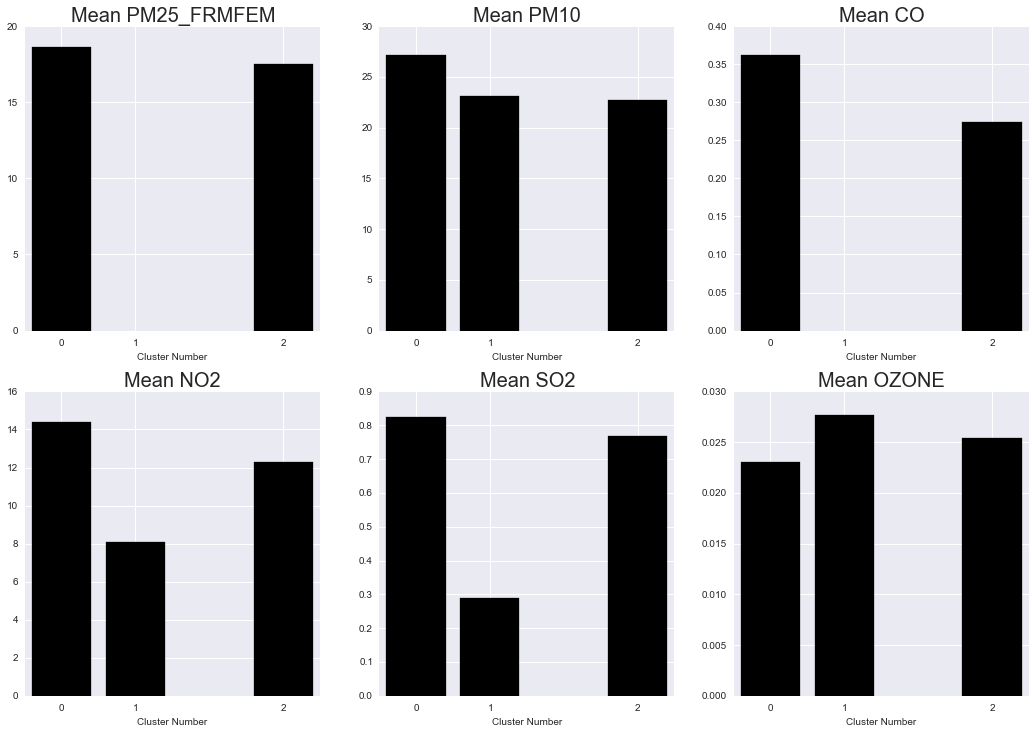

In [554]:
fig = plt.figure(figsize=(18,12))
names=['0','1','2','3']
plt.subplot(2, 3, 1)
plt.bar(fr_means.index,fr_means['PM25_FRMFEM'],color='black',align='center')
plt.title('Mean PM25_FRMFEM',fontsize=20)
plt.xticks(fr_means.index, names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)

plt.subplot(2, 3, 2)
plt.bar(fr_means.index,fr_means['PM10'],color='black',align='center')
plt.title('Mean PM10',fontsize=20)
plt.xticks(fr_means.index, names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)

plt.subplot(2, 3, 3)
plt.bar(fr_means.index,fr_means['CO'],color='black',align='center')
plt.title('Mean CO',fontsize=20)
plt.xticks(fr_means.index, names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)
  
plt.subplot(2, 3, 4)
plt.bar(fr_means.index,fr_means['NO2'],color='black',align='center')
plt.title('Mean NO2',fontsize=20)
plt.xticks(fr_means.index, names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)

plt.subplot(2, 3, 5)
plt.bar(fr_means.index,fr_means['SO2'],color='black',align='center')
plt.title('Mean SO2',fontsize=20)
plt.xticks(fr_means.index, names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)

plt.subplot(2, 3, 6)
plt.bar(fr_means.index,fr_means['OZONE'],color='black',align='center')
plt.title('Mean OZONE',fontsize=20)
plt.xticks(fr_means.index, names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)


In [555]:
fr_p_clusts 

,CO,NO2,OZONE,PM10,PM25_FRMFEM,SO2,Cluster
city,,,,,,,
Charleville-Mezieres,NaN,10.551064,0.022737,25.435000,NaN,0.246565,0
Valence,NaN,13.289894,0.025374,NaN,19.3590,1.301908,3
Bethune,NaN,10.278191,0.020714,26.630000,NaN,0.767939,0
Sarrebruck - Forbach,NaN,10.507270,0.026475,22.453000,NaN,2.470992,3
Quimper,NaN,8.092021,0.025846,25.747000,NaN,0.170229,0
Toulon,NaN,19.974823,0.027073,30.476500,16.5000,NaN,0
Colmar,NaN,16.182979,0.023788,25.150500,NaN,2.056870,0
Tarbes,NaN,11.246011,0.026524,22.429000,NaN,0.152481,3
Bourges,NaN,8.527660,0.025440,20.624000,NaN,0.155725,3


In [556]:
fr_p_clusts.to_csv("clusters_knn_france.csv",index=False,na_rep='NA')